In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import json
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import sys
sys.path.append('/home/ros/llm_robot')
from utils.camera import capture_d455_images, load_intrinsics

In [255]:
from pymycobot import MyCobot280

mc = MyCobot280("/dev/ttyACM1", 115200)
mc.send_angles([-90,0,0,0,0,0], 50)

1

In [583]:
c_path, d_path, intr_path = capture_d455_images()

img = cv2.imread(c_path, cv2.IMREAD_COLOR)
# val = 80
# array = np.full(img.shape, (val, val, val), dtype=np.uint8)
# sub_img = cv2.subtract(img, array)

In [584]:
best_model = "/home/ros/llm_robot/yolo/runs/pose/yolo11n_640_500ep_reannotated/weights/best.pt"
model = YOLO(best_model)
result = model.predict(img)
result[0].show()


0: 384x640 1 cube, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [585]:
# camera_matrix, dist_coeffs = load_intrinsics("/home/ros/llm_robot/data/Calibration/Eye-to-Hand11/camera_intrinsics_result.json")
camera_matrix, dist_coeffs = load_intrinsics("/home/ros/Eye-to-Hand/data/camera_calibration/camera_params.json")
box = result[0].boxes.xyxy.cpu().numpy()
x1, y1, x2, y2 = box[0]
keypoints_xy = result[0].keypoints.xy.cpu().numpy()

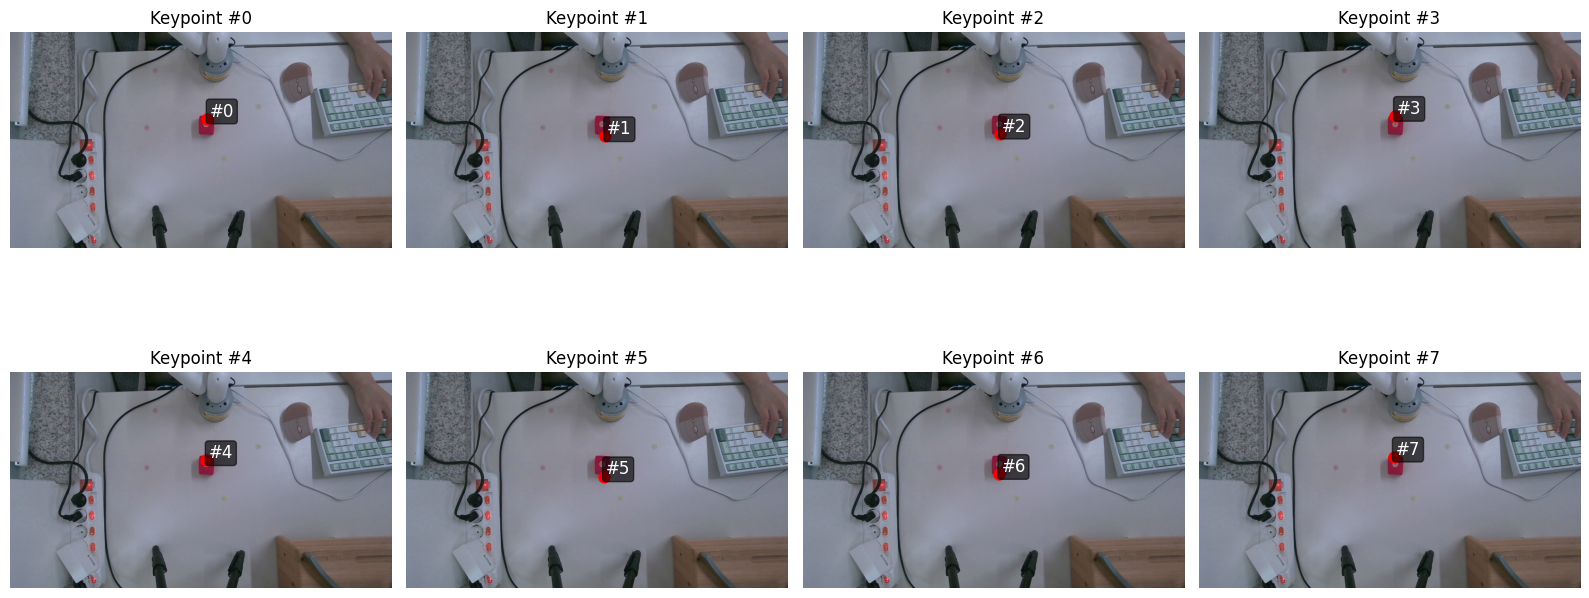

In [586]:
img = cv2.imread(c_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
keypoints = np.array(keypoints_xy[0])

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    ax.imshow(img)
    x, y = keypoints[idx]
    ax.scatter(x, y, c='red', s=60)
    ax.text(x + 5, y - 5, f"#{idx}", color='white', fontsize=12,
            bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.2'))
    ax.set_title(f"Keypoint #{idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [587]:
raw_depth = np.load(d_path)
uv_coords = keypoints_xy[0].astype(int)

# 각 키포인트에 대응되는 depth 추출
keypoint_depths = []
for u, v in uv_coords:
    z = raw_depth[v, u]
    keypoint_depths.append(z)
keypoint_depths = np.array(keypoint_depths)
keypoint_depths

array([515,   0, 517, 515, 516,   0, 518, 515], dtype=uint16)

### 큐브의 기준점 지정
직육면체는 꼭지점 간의 상대적인 거리가 일정하다는 기하학적인 특징이 존재한다.\
따라서 큐브의 가로 세로 높이를 알고 있다면, 객체 좌표계 기준의 3D Keypoint 좌표를 직접 정의할 수 있다. 
- 가로`L_x`: key2~key3
- 세로`L_y`: key2~key1
- 높이`L_z`: key2~key6

한쪽 꼭짓점을 원점 $(0, 0, 0)$으로 설정하고 나머지 7개 꼭짓점의 상대적인 3D 좌표를 정의
- P_1=(0,0,0)
- P_2=(L_x,0,0)
- P_3=(0,L_y,0)
- P_4=(0,0,L_z)
- P_5=(L_x,L_y,0)
- P_6=(L_x,0,L_z)
- P_7=(0,L_y,L_z)
- P_8=(L_x,L_y,L_z)

In [297]:
def get_3d_keypoints(keypoints_xy, d_path, camera_matrix, dist_coeffs, depth_scale = 0.001):
    u, v = keypoints_xy.astype(int)
    raw_depth = np.load(d_path)
    z = raw_depth[v, u] * 0.001
    
    # 픽셀 좌표 보정
    # undistortPoints()를 활용하여 정규화된 좌표를 반환 
    pixel = np.array([[[u, v]]], dtype=np.float32)    # (1, 1, 2)
    undistorted = cv2.undistortPoints(pixel, camera_matrix, dist_coeffs)
    cx_u, cy_u = undistorted[0][0]
    
    x_cam = round(cx_u * z, 4)
    y_cam = round(cy_u * z, 4)
    z_cam = round(z, 4)
    
    return x_cam, y_cam, z_cam

def get_uclidian_distance(key1, key2):
    x1, y1, z1 = key1
    x2, y2, z2 = key2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

In [298]:
key1 = get_3d_keypoints(keypoints_xy[0][1], d_path, camera_matrix, dist_coeffs)
key2 = get_3d_keypoints(keypoints_xy[0][2], d_path, camera_matrix, dist_coeffs)
key3 = get_3d_keypoints(keypoints_xy[0][3], d_path, camera_matrix, dist_coeffs)
key6 = get_3d_keypoints(keypoints_xy[0][6], d_path, camera_matrix, dist_coeffs)
print(key1, key2, key3, key6)

(np.float64(0.0365), np.float64(-0.0227), np.float64(0.538)) (np.float64(0.0157), np.float64(-0.0181), np.float64(0.541)) (np.float64(0.0118), np.float64(-0.0523), np.float64(0.521)) (np.float64(0.0089), np.float64(-0.0136), np.float64(0.548))


In [299]:
Lx = get_uclidian_distance(key2,key3)
Ly = get_uclidian_distance(key2,key1)
Lz = get_uclidian_distance(key2,key6)

print(Lx, Ly, Lz)

0.03981017457886866 0.02151278689523977 0.010746627377926532


In [300]:
# 3D Object Points
object_points = np.array([
    [0, 0, Lz],
    [Lx, 0, Lz],
    [Lx, Ly, Lz],
    [0, Ly, Lz],
    [0, 0, 0],
    [Lx, 0, 0],
    [Lx, Ly, 0],
    [0, Ly, 0],
])

In [301]:
object_points2 = np.array([
    [0, 0, 0],
    [Lx, 0, 0],
    [0, Ly, 0],
    [0, 0, Lz],
    [Lx, Ly, 0],
    [Lx, 0, Lz],
    [0, Ly, Lz],
    [Lx, Ly, Lz]
])

In [302]:
ret, rvec, tvec = cv2.solvePnP(
    object_points*1000,
    keypoints_xy[0],
    camera_matrix,
    dist_coeffs,
    flags=cv2.SOLVEPNP_EPNP
)

pnp_xyz = tvec.flatten()*0.001
R_cam, _ = cv2.Rodrigues(rvec)
pnp_xyz,R_cam

(array([   0.027896,   -0.057851,     0.59781]),
 array([[    0.15651,    -0.89268,     0.42264],
        [    0.95757,    0.032292,    -0.28639],
        [    0.24201,     0.44952,     0.85986]]))

In [303]:
ret, rvec2, tvec2 = cv2.solvePnP(
    object_points2*1000,
    keypoints_xy[0],
    camera_matrix,
    dist_coeffs,
    flags=cv2.SOLVEPNP_EPNP
)

pnp_xyz2 = tvec2.flatten()*0.001
R_cam2, _ = cv2.Rodrigues(rvec2)
pnp_xyz2,R_cam2

(array([   0.034622,   -0.053642,     0.67887]),
 array([[    0.15806,    -0.61946,    -0.76895],
        [     0.1465,     0.78483,    -0.60214],
        [     0.9765,   -0.017476,      0.2148]]))

### cam2base 변환

In [304]:
cam_xyz = get_3d_keypoints(keypoints_xy[0].mean(axis=0), d_path, camera_matrix, dist_coeffs)
cam_xyz

(np.float64(0.0196), np.float64(-0.0342), np.float64(0.519))

In [305]:
keypoints_xy[0].mean(axis=0)

array([     441.42,      209.39], dtype=float32)

In [306]:
np.array([(x1+x2)//2, (y1+y2)//2])

array([        440,         208], dtype=float32)

In [307]:
def cam2base(cam_xyz, cam2base_path):
    cam_xyz = np.array(cam_xyz).reshape(3, 1)
    cam_homog = np.append(cam_xyz, 1.0)

 
    with open(cam2base_path, "r") as f:
        data = json.load(f)
        
    R_cam2base = np.array(data["R_cam2base"]).reshape(3,3)
    t_cam2base = np.array(data["t_cam2base"]).reshape(3, 1)

    T_cam2base = np.eye(4)
    T_cam2base[:3, :3] = R_cam2base
    T_cam2base[:3, 3] = t_cam2base.flatten()

    # 좌표축 보정
    T_flip_z = np.array([
        [ 1,  0,  0],
        [ 0,  1,  0],
        [ 0,  0, -1]
    ]) 

    R_corrected = T_flip_z @ R_cam2base
    t_corrected = T_flip_z @ t_cam2base

    T_cam2base_corrected = np.eye(4)
    T_cam2base_corrected[:3, :3] = R_corrected
    T_cam2base_corrected[:3, 3] = t_corrected.flatten()


    # XYZ 변환
    base_homog =   T_cam2base_corrected @ cam_homog
    base_xyz_homog = base_homog[:3]*1000      # X, Y, Z (병진 포함)
    # 최종 [x,y,z, r,p,y]
    out = np.concatenate([base_xyz_homog])
    out = [float(np.round(v, 2)) for v in out]
    return out

In [308]:
### v3
def rotation_matrix_to_rpy(R):
    sy = np.sqrt(R[0,0] * R[0,0] + R[1,0] * R[1,0])
    singular = sy < 1e-6

    if not singular:
        roll = np.arctan2(R[2,1], R[2,2])
        pitch = np.arctan2(R[2,0], sy)
        yaw = np.arctan2(R[1,0], R[0,0])
    else:
        roll = np.arctan2(-R[1,2], R[1,1])
        pitch = np.arctan2(R[2,0], sy)
        yaw = 0

    # 라디안을 도 단위로 변환
    roll = np.degrees(roll)
    pitch = np.degrees(pitch)
    yaw = np.degrees(yaw)

    return roll, pitch, yaw

def to_4x4(R, t):
    T = np.eye(4, dtype=np.float32)
    T[:3, :3] = R.astype(np.float32)
    T[:3, 3] = t.reshape(3).astype(np.float32)
    return T

def cam2base_v3(cam_xyz, cam2base_path):
    cam_xyz = np.array(cam_xyz).reshape(3, 1)
    cam_homog = np.append(cam_xyz, 1.0)

 
    with open(cam2base_path, "r") as f:
        data = json.load(f)
        
    R_cam2base = np.array(data["R_cam2base"]).reshape(3,3)
    t_cam2base = np.array(data["t_cam2base"]).reshape(3, 1)

    # 좌표축 보정
    T_flip_z = np.array([
        [ 1,  0,  0],
        [ 0,  1,  0],
        [ 0, 0,  1]
    ]) 

    R_corrected = T_flip_z @ R_cam2base
    t_corrected = T_flip_z @ t_cam2base

    T_cam2base_corrected = to_4x4(R_corrected, t_corrected)

    # XYZ 변환
    base_homog = T_cam2base_corrected @ cam_homog
    base_xyz_homog = base_homog[:3]*1000      # X, Y, Z (병진 포함)

    # 최종 [x,y,z, r,p,y]
    out = np.concatenate([base_xyz_homog])
    out = [float(np.round(v, 2)) for v in out]
    return out


In [309]:
cam2base_path = "/home/ros/llm_robot/data/Calibration/Eye-to-Hand11/cam2base_icp_point.json"
x,y,z = cam2base(cam_xyz, cam2base_path)
print(x,y,z)

108.16 -40.54 -9.46


In [310]:
cam2base_path = "/home/ros/llm_robot/data/Calibration/Eye-to-Hand11/cam2base_icp_point.json"
# cam2base_path = "/home/ros/Eye-to-Hand/src/cam2base.json"
x2,y2,z2 = cam2base_v3(cam_xyz, cam2base_path)
print(x2,y2,z2)

108.16 -40.54 9.46


In [538]:
import open3d as o3d
def create_roi_pcd(depth_npy_path, result, camera_matrix, depth_scale=0.001):
    """
    YOLO bounding box + depth → ROI PointCloud 생성 (카메라 좌표계)

    Args:
        depth_npy_path: npy 저장된 depth map 경로
        yolo_output: YOLO 결과 (boxes.xyxy 등에서 [x1,y1,x2,y2])
        camera_matrix: 3x3 intrinsic matrix (fx, fy, cx, cy)
        depth_scale: depth scaling factor (기본=0.001, mm→m)

    Returns:
        o3d.geometry.PointCloud (카메라 좌표계)
    """
    # Depth 로드
    depth = np.load(depth_npy_path)

    # ROI 좌표
    box = result[0].boxes.xyxy.cpu().numpy()
    x1, y1, x2, y2 = box[0].astype(int)
    roi_depth = depth[y1:y2, x1:x2]

    # Intrinsics
    fx, fy = camera_matrix[0,0], camera_matrix[1,1]
    cx, cy = camera_matrix[0,2], camera_matrix[1,2]

    # ROI 중심 보정
    roi_cx = cx - x1
    roi_cy = cy - y1

    # Mask (유효 depth만 사용)
    zs = roi_depth.astype(np.float32) * depth_scale
    mask = (zs > 0)
    vs, us = np.where(mask)
    zs = zs[vs, us]

    xs = (us - roi_cx) * zs / fx
    ys = (vs - roi_cy) * zs / fy

    pts = np.stack([xs, ys, zs], axis=1).astype(np.float32)
    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts))

    return pcd


def estimate_6dof_yolo_pca(roi_pcd, cam2base_path):
    """
    YOLO에서 얻은 cam_point로 XYZ를,
    ROI point cloud의 PCA로 RPY를 추정
    """
    with open(cam2base_path, "r") as f:
        data = json.load(f)
        
    R_cam2base = np.array(data["R_cam2base"]).reshape(3,3)

    # --- PCA 자세 추정 ---
    pts = np.asarray(roi_pcd.points)
    cov = np.cov(pts.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, order]

    R_pca_cam = np.eye(3)
    R_pca_cam[:,0] = eigvecs[:,0]
    R_pca_cam[:,1] = eigvecs[:,1]
    R_pca_cam[:,2] = np.cross(R_pca_cam[:,0], R_pca_cam[:,1])
    R_pca_base = R_cam2base @ R_pca_cam

    roll, pitch, yaw = rotation_matrix_to_rpy(R_pca_base)
    return roll, pitch, yaw 

def transform_pcd_cam2base(pcd_cam, cam2base_json):
    """
    카메라 좌표계 PCD → 로봇 base 좌표계 PCD 변환
    
    Args:
        pcd_cam (o3d.geometry.PointCloud): 카메라 좌표계 PCD
        cam2base_json (str): cam2base.json 경로
    
    Returns:
        o3d.geometry.PointCloud: base 좌표계 PCD
    """
    # cam2base extrinsic 불러오기
    with open(cam2base_json, "r") as f:
        data = json.load(f)
    R_cam2base = np.array(data["R_cam2base"], dtype=np.float32)
    t_cam2base = np.array(data["t_cam2base"], dtype=np.float32).reshape(3,1)

    # cam → base 변환행렬 (4x4)
    T_cam2base = np.eye(4, dtype=np.float32)
    T_cam2base[:3,:3] = R_cam2base
    T_cam2base[:3, 3] = t_cam2base.flatten()

    # PCD 변환
    pcd_base = pcd_cam.transform(T_cam2base)
    return pcd_base

In [578]:
import open3d as o3d

roi_pcd = create_roi_pcd(d_path, result, camera_matrix)
roll, pitch, yaw  = estimate_6dof_yolo_pca(roi_pcd, cam2base_path)
roll, pitch, yaw 

(np.float64(81.23736585295009),
 np.float64(-20.78782167763886),
 np.float64(3.9521598307708365))

In [579]:
cam2base_path

'/home/ros/llm_robot/data/Calibration/Eye-to-Hand11/cam2base_icp_point.json'

In [ ]:
roi_pcd = create_roi_pcd(d_path, result, camera_matrix)
# o3d.visualization.draw_plotly([roi_pcd])

In [ ]:
roi_pcd_base = transform_pcd_cam2base(roi_pcd, cam2base_path)
# o3d.visualization.draw_plotly([roi_pcd_base])

In [ ]:
cam2base_path2 = "/home/ros/llm_robot/data/Calibration/Eye-to-Hand11/cam2base.json"
roi_pcd_base2 = transform_pcd_cam2base(roi_pcd, cam2base_path2)
# o3d.visualization.draw_plotly([roi_pcd_base2])

In [359]:
import numpy as np
import open3d as o3d
import json
from scipy.spatial.transform import Rotation as R

def roi_depth_to_pcd(d_path, yolo_outputs, camera_matrix, depth_scale=0.001):
    depth = np.load(d_path)

    # 1. ROI 영역 잘라내기
    x1, y1, x2, y2 = yolo_outputs[0].boxes.xyxy.cpu().numpy()[0].astype(int)
    roi_depth = depth[y1:y2, x1:x2]

    # 2. ROI intrinsic 생성
    fx = camera_matrix[0][0]  # 수평 초점 거리
    fy = camera_matrix[1][1]  # 수직 초점 거리
    ppx = camera_matrix[0][2] # center x
    ppy = camera_matrix[1][2] # center y

    roi_ppx = ppx - x1
    roi_ppy = ppy - y1

    roi_intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width=roi_depth.shape[1],
        height=roi_depth.shape[0],
        fx=fx,
        fy=fy,
        cx=roi_ppx,
        cy=roi_ppy
    )

    depth_o3d = o3d.geometry.Image(roi_depth.astype(np.uint16))
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_o3d,
    roi_intrinsic,
    depth_scale=1.0/depth_scale,
    depth_trunc=3.0,  # 최대 거리[m], 필요시 조정
    stride=1
)

    return pcd

def to_4x4(R, t):
    T = np.eye(4, dtype=np.float32)
    T[:3, :3] = R.astype(np.float32)
    T[:3, 3] = t.reshape(3).astype(np.float32)
    return T

def level_correction_from_plane_normal(n_base):
    """베이스 좌표에서 얻은 평면 법선 n_base를 +Z로 정렬하는 보정 회전 ΔR 반환"""
    n = n_base / np.linalg.norm(n_base)
    z = np.array([0., 0., 1.])
    # 부호 통일(법선이 -Z면 뒤집기)
    if np.dot(n, z) < 0: 
        n = -n
    v = np.cross(n, z)
    s = np.linalg.norm(v)
    c = float(np.dot(n, z))
    if s < 1e-12:          # 이미 정렬됨
        return np.eye(3)
    vx = np.array([[0, -v[2], v[1]],
                   [v[2], 0, -v[0]],
                   [-v[1], v[0], 0]], dtype=float)
    dR = np.eye(3) + vx + vx @ vx * ((1 - c) / (s * s))
    return dR


# 1) ROI PCD 생성 (ROI intrinsics 사용)
pcd_roi_cam = roi_depth_to_pcd(d_path, result, camera_matrix)

# 2) cam->base 로드
with open(cam2base_path, "r") as f:
    data = json.load(f)
R_cam2base = np.array(data["R_cam2base"]).reshape(3,3).astype(np.float32)
t_cam2base = np.array(data["t_cam2base"]).reshape(3).astype(np.float32)  # [m]
T_cam2base = to_4x4(R_cam2base, t_cam2base)

R_obj_cam, _ = cv2.Rodrigues(rvec)          # 물체→카메라 회전
t_obj_cam = tvec.flatten()*0.001            # [m]

T_obj_cam  = to_4x4(R_obj_cam, np.array(cam_xyz).reshape(3,1)) 

T_obj_base = T_cam2base @ T_obj_cam

In [360]:
def rpy_to_T_base(rpy, pos):
    R_base = R.from_euler('xyz', rpy, degrees=True).as_matrix()
    T = np.eye(4)
    T[:3, :3] = R_base
    T[:3, 3] = pos
    return T

def create_v_gripper_mesh(finger_length=0.08,   # 집게 길이 [m]
                          finger_thickness=0.01, # 두께 [m]
                          opening_width=0.04):   # V자 벌어진 폭 [m]
    """
    V자 형태의 간단한 Gripper Mesh 생성
    
    Args:
        finger_length (float): 집게 손가락 길이 (m)
        finger_thickness (float): 손가락 두께 (m)
        opening_width (float): 두 손가락 끝단 간격 (m)
    
    Returns:
        o3d.geometry.TriangleMesh: V자형 그리퍼 mesh
    """
    # 손가락 1 (왼쪽)
    finger1 = o3d.geometry.TriangleMesh.create_box(
        width=finger_thickness,
        height=finger_length,
        depth=finger_thickness
    )
    finger1.paint_uniform_color([0.8, 0.1, 0.1])
    finger1.translate([-opening_width/2, 0, -finger_thickness/2])

    # 손가락 2 (오른쪽)
    finger2 = o3d.geometry.TriangleMesh.create_box(
        width=finger_thickness,
        height=finger_length,
        depth=finger_thickness
    )
    finger2.paint_uniform_color([0.1, 0.1, 0.8])
    finger2.translate([opening_width/2 - finger_thickness, 0, -finger_thickness/2])

    # V자 형태로 기울이기
    R_left = finger1.get_rotation_matrix_from_xyz([0, 0, np.radians(20)])
    R_right = finger2.get_rotation_matrix_from_xyz([0, 0, np.radians(-20)])
    finger1.rotate(R_left, center=finger1.get_center())
    finger2.rotate(R_right, center=finger2.get_center())

    # 병합
    gripper = finger1 + finger2
    gripper.compute_vertex_normals()

    return gripper


def single_axis_lineset(T, axis_idx, length=0.04, color=(1,0,0)):
    axis_start = T[:3, 3]
    axis_end = axis_start + T[:3, axis_idx] * length
    axis_line = o3d.geometry.LineSet()
    axis_line.points = o3d.utility.Vector3dVector([axis_start, axis_end])
    axis_line.lines = o3d.utility.Vector2iVector([[0, 1]])
    axis_line.colors = o3d.utility.Vector3dVector([color])
    return axis_line

In [ ]:
ee_rpy_deg = (roll, pitch, yaw )    
ee_pos_base = T_obj_base[:3,3] + np.array([0, 0, 0.03])  # 객체 위 3cm

T_grip_base = rpy_to_T_base(ee_rpy_deg, ee_pos_base)

gripper_mesh = create_v_gripper_mesh(finger_length=0.08, finger_thickness=0.01, opening_width=0.05)
gripper_in_base = o3d.geometry.TriangleMesh(gripper_mesh)  # copy
gripper_in_base.transform(T_grip_base)

x_ls = single_axis_lineset(T_obj_base, axis_idx=0, length=0.04, color=(1,0,0))  # Roll/X
y_ls = single_axis_lineset(T_obj_base, axis_idx=1, length=0.04, color=(0,1,0))  # Pitch/Y
z_ls = single_axis_lineset(T_obj_base, axis_idx=2, length=0.04, color=(0,0,1))  # Yaw/Z


fig = o3d.visualization.draw_plotly([roi_pcd_base, gripper_in_base, x_ls, y_ls, z_ls])
print(f"{roll:.2f}°, {pitch:.2f}°, {yaw:.2f}°")

81.24°, -20.79°, 3.95°
